# Spacecraft Pose Estimation Model Example

In [1]:
%matplotlib inline
USE_GPU = True

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from dataloader_utils import *
torch.manual_seed(42)
from PIL import Image, ImageDraw
from matplotlib import cm
import torchvision.transforms.functional as tF

if USE_GPU:
    print(torch.cuda.is_available())

True


## Testing dataloader

In [3]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

sample_transform = transforms.Compose([
    transforms.RandomRotation((-30, 30))
])

sample_dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=None)

Bounding box [x_min, y_min, x_max, y_max]: [571.89217841 547.14270504 901.62193347 509.08239738]


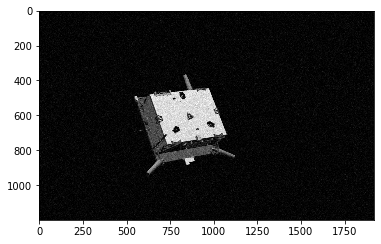

In [4]:
i = 895
img, label, K = sample_dataset[i]
plt.figure()
plt.imshow(img)
print("Bounding box [x_min, y_min, x_max, y_max]: {}".format(label[-4:]))

## Dataloading

In [5]:
class JointRescrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        target_q = target[:4]
        target_r = target[4:7]
        target_db = target[7:11] 
        target_bb = target[11:]

        sz = self.size[0]
        # Determine crop size that will still capture entire satellite
        x = [target_bb[i] for i in range(0, len(target_bb), 2)]
        y = [target_bb[i] for i in range(1, len(target_bb), 2)]
        xmin = min(x); xmax = max(x)
        ymin = min(y); ymax = max(y)
        fS = 1.75
        dx = xmax - xmin
        dy = ymax - ymin
        self.cropSize = int(fS * max(dx, dy))
        if self.cropSize > min(img.size):
            self.cropSize = min(img.size)
#         print("cropSize: ", cropSize)
        
        # Crop Image
        self.cx = sum(x)/len(x)
        self.cy = sum(y)/len(y)
        top = self.cy - self.cropSize/2
        left = self.cx - self.cropSize/2
        img = tF.crop(img, top, left, self.cropSize, self.cropSize)
        
        # Crop translation of points
        xtarget = [self.cropSize/2 + (i - self.cx) for i in x]
        ytarget = [self.cropSize/2 + (i - self.cy) for i in y]
        target_bb = [None]*(len(xtarget)+len(ytarget))
        target_bb[::2] = xtarget
        target_bb[1::2] = ytarget
        target_bb = np.array(target_bb)
        
        # Rescale to input size
        norm = img.size[1]
        img = tF.resize(img, sz)
        target_bb = [sz * i / norm for i in target_bb]

        # Update db from bb
        xa = target_bb[0::2]
        ya = target_bb[1::2]
        target_db = [min(xa), min(ya), max(xa), max(ya)]
        
        target = np.concatenate((target_q, target_r, target_db, target_bb))

        return img, target

In [6]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(target)

In [7]:
class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

In [8]:
class JointNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, img, target):
        # Expects img to be a tensor
        timg = tF.normalize(img, self.mean, self.std)
        return (timg, target)

In [9]:
# Transforms
train_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
    JointNormalize([0.5], [0.5])
])

sanity_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

In [10]:
# Datasets
# NOTE: we don't have the labels for the test set, so we need to split the training set
training_dataset = SpeedDataset(
    split="train",
    split_index=1000, # used to make a smaller training set for dev
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=train_transform
)

sanity_dataset = SpeedDataset(
    split="train",
    sanity_check=100,
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=sanity_transform
)

[129.39001083162302, 106.49745510471199]

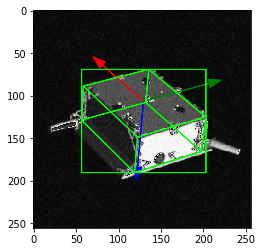

In [11]:
# TEST
sample, target, K = training_dataset[17]
sample2, target2, K2 = training_dataset[80]
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(sample), target.numpy())
image2, label2 = JointRescrop((256, 256))(tF.to_pil_image(sample2), target2.numpy())
training_dataset.visualize(image2, label2, K2, factor=0.6, bbox=True, dbox=True)

In [12]:
(train_len, test_len) = (int(0.85*len(training_dataset)), int(0.15*len(training_dataset)))
assert train_len + test_len == len(training_dataset)
train_dataset, test_dataset = torch.utils.data.random_split(training_dataset, (train_len, test_len))

In [13]:
# Dataloading
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=WORKERS, shuffle=False, drop_last=True) # NOTE: set shuffle to True!
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=WORKERS, shuffle=False, drop_last=True)

## Existing network implementations (1/2)

The following is a pytorch implementation of [Deep3dBox](https://arxiv.org/pdf/1612.00496.pdf). Geometric constraints are used to solve for the translation (even though it is known to lock errors in if the 2D bounding box is inaccurate; see [MonoPSR](https://arxiv.org/pdf/1904.01690.pdf) or [Cascade geometric constratins](https://arxiv.org/pdf/1909.01867.pdf) for better alternatives). However, all these approaches focus on 3D bounding box estimation for cars and as a result, they can make pretty big assumptions about the orientation of the vehicle (i.e., roll and pitch equal to zero). These papers use multi-task CNN and multi-bin losses and would need to be extended to recover the full 6DOF.

In [14]:
# Pre-trained layers
DEEP3D = False
if DEEP3D:
    vgg = models.vgg19_bn(pretrained=True)

In [15]:
# Input size: 224x224 (imposed by vgg pretrained layers)

def OrientationLoss(orient_batch, orientGT_batch, confGT_batch):

    batch_size = orient_batch.size()[0]
    indexes = torch.max(confGT_batch, dim=1)[1]

    # extract just the important bin
    orientGT_batch = orientGT_batch[torch.arange(batch_size), indexes]
    orient_batch = orient_batch[torch.arange(batch_size), indexes]

    theta_diff = torch.atan2(orientGT_batch[:,1], orientGT_batch[:,0])
    estimated_theta_diff = torch.atan2(orient_batch[:,1], orient_batch[:,0])

    return -1 * torch.cos(theta_diff - estimated_theta_diff).mean()


class Deep3dBoxNet(nn.Module):
    def __init__(self, features=None, bins=2, w = 0.4):
        super(Deep3dBoxNet, self).__init__()
        self.bins = bins
        self.w = w
        self.features = features
        self.orientation = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins*2) # to get sin and cos
                )
        self.confidence = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins),
                    # nn.Softmax()
                    #nn.Sigmoid()
                )
        self.dimension = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 3)
                )

    def forward(self, x):
        x = self.features(x) # 512 x 7 x 7
        x = x.view(-1, 512 * 7 * 7)
        orientation = self.orientation(x)
        orientation = orientation.view(-1, self.bins, 2)
        orientation = F.normalize(orientation, dim=2)
        confidence = self.confidence(x)
        dimension = self.dimension(x)
        return orientation, confidence, dimension

In [16]:
# Testing model with pretrained weights (epoch10) on Kitti
if DEEP3D:
    weight_filepath = '../weights/epoch_10.pkl'
    if USE_GPU == True:
        model = Deep3dBoxNet(features=vgg.features, bins=2).cuda()
    else:
        model = Deep3dBoxNet(features=vgg.features, bins=2)
    checkpoint = torch.load(weight_filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    # model.eval()

## Existing network implementations (2/2)
The following is an end-to-end implementation based on [USRO](https://arxiv.org/pdf/1907.04298.pdf) which seeks simplicity over efficiency. The team finished in 3rd place using resnet101 as their backbone. This implementation relies on resnet34 instead for computational reasons. Being more straightforward, this implementation is more suited to a study of domain adaptation.

In [17]:
# Pre-trained layers
resnet = models.resnet34(pretrained=True)

In [18]:
class URSONet(nn.Module):
    def __init__(self, criterion=None):
        super(URSONet, self).__init__()

        # Resnet backbone
        self.resnet = nn.Sequential(*list(resnet.children())[:-2]) 
        self.conv6 = nn.Conv2d(512, 1024, 3, 2)
        self.bn1 = nn.BatchNorm2d(1024)
        
        # Translation branch: t = [tx, ty, tz]
        # self.fc_t = nn.Linear(4*4*1024, 3)

        self.fc_t1 = nn.Linear(3*3*1024, 1024)
        self.fc_t2 = nn.Linear(1024, 3)

        # Attitude branch: q = [q0, q1, q2, q3]
        # self.fc_att = nn.Linear(4*4*1024, 4)
        self.fc_att1 = nn.Linear(3*3*1024, 1024)
        self.fc_att2 = nn.Linear(1024, 4) # unit-quaternions
        # self.fc_att2 = nn.Linear(1024, 3) # MRP        
    
    def forward(self, input, gt=None):
        # Input size: 256x256
        # x = F.relu(self.resnet(input)) # NOTE: should we add activation after resnet?
        x = self.resnet(input)
        x = F.relu(self.bn1(self.conv6(x)))
        # Reshape after bottleneck
        x_t = x.view(-1, 3*3*1024)
        x_att = x.view(-1, 3*3*1024)

        # T regression
        x_t = F.relu(self.fc_t1(x_t))
        x_t = self.fc_t2(x_t)

        # q regression
        x_att = F.relu(self.fc_att1(x_att))
        x_att = torch.tanh(self.fc_att2(x_att))


        return x_t, x_att
        # return x_att


### Training

In [19]:
OVERFIT=False
TRAINING=True
BETA=1
if OVERFIT:
    overfit_net = URSONet()
    if USE_GPU:
        overfit_net = overfit_net.cuda()

In [20]:
def get_of_optimizer(net):
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

In [21]:
# Loss functions from PoseNet
class PoseNetCriterion(torch.nn.Module):
    def __init__(self, beta = 512.0, learn_beta=False, sx=0.0, sq=-3.0):
        super(PoseNetCriterion, self).__init__()
        self.loss_fn = torch.nn.L1Loss()
        self.learn_beta = learn_beta
        if not learn_beta:
            self.beta = beta
        else:
            self.beta = 1.0
        self.sx = torch.nn.Parameter(torch.Tensor([sx]), requires_grad=learn_beta)
        self.sq = torch.nn.Parameter(torch.Tensor([sq]), requires_grad=learn_beta)

    def forward(self, t_gt, t, att_gt, att):
        # Translation loss
        loss_t = torch.exp(-self.sx) * self.loss_fn(t, t_gt)
        print(loss_t)
        # Rotation loss
        loss_att = torch.exp(-self.sq) * self.beta * self.loss_fn(att, att_gt) + self.sq
        print(loss_att)
        return loss_t + loss_att

In [22]:
def q_to_mrp(q):
    return q[1:4] / (1 + q[0])

In [23]:
def mrp_to_q(sigma):
    s2 = np.dot(sigma.T, sigma)
    q0 = (1-s2)/(1+s2)
    qi = 2*sigma/(1+s2)
    return np.concatenate((np.array([q0]), qi))

In [24]:
def translation_loss2(t_gt, t_pred, bbox, K):
    # WIP: Donkey Tail Hypothesis --> regress [du, dv, tz]
    u = (bbox[:, [0]] + bbox[:, [2]]) / 2.0
    v = (bbox[:, [1]] + bbox[:, [3]]) / 2.0
    # print(u, v)
    cx = K[:, [0], [2]]
    cy = K[:, [1], [2]]
    fx = K[:, [0], [0]]
    fy = K[:, [1], [1]]
    # Calculate true deviation from bbox center
#     du = fx*t_gt[:, [0]] - u + cx*t_gt[:, [2]]
#     dv = fy*t_gt[:, [1]] - v + cy*t_gt[:, [2]]
    du = fx*t_gt[:, [0]]/t_gt[:, [2]] - u + cx
    dv = fy*t_gt[:, [1]]/t_gt[:, [2]] - v + cy
    gt = torch.cat((du.float(), dv.float(), t_gt[:, [2]]), -1)
    return torch.mean(torch.norm((gt - t_pred)/torch.norm(gt)))

In [25]:
def translation_loss(t_gt, t_pred):
    return torch.mean(torch.norm((t_gt - t_pred)/torch.norm(t_gt)))

In [26]:
def attitude_loss(att_gt, att_pred):
    bs = att_gt.shape[0]
    att_pred = F.normalize(att_pred, p=2, dim=1)
    prod = torch.bmm(att_gt.view(bs, 1, 4), att_pred.view(bs, 4, 1)).reshape(bs, 1)
    loss = 1 - prod ** 2
    # sigma = att_gt[0][1:4] / (1 + att_gt[0][0])
    # s2 = torch.norm(sigma) ** 2
    # if s2 > 1.0:
    #     sigma /= -s2
    # return torch.sum(torch.norm(sigma[None] - att_pred, p=2))
    return torch.mean(loss)


In [27]:
def train(train_loader, net, optimizer, loss_graph):
    epoch_loss = 0
    epoch_loss_t = 0
    epoch_loss_att = 0

    for i, data in enumerate(train_loader):
        inputs, target, K = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
            K = K.cuda()
        att_gt = target[:, :4].float()
        t_gt = target[:, 4:7].float()

        optimizer.zero_grad()
        t, att = net(inputs)
        # t = net(inputs)
        # att = net(inputs)

#         L_t = translation_loss(t_gt, t)
        L_t = translation_loss2(t_gt, t, target[:, 7:11], K)
        L_att = attitude_loss(att_gt, att)
        total_loss = L_t + BETA*L_att  #+ (torch.abs(torch.mean(1 - torch.norm(att))))
        loss_graph[0].append(total_loss.item())
        loss_graph[1].append(L_t.item())
        loss_graph[2].append(L_att.item())

        # loss_graph.append(total_loss.item())
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader)

In [28]:
def train2(train_loader, net, criterion, optimizer, loss_graph):
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        inputs, target, K = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
            K = K.cuda()
        att_gt = target[:, :4].float()
        t_gt = target[:, 4:7].float()

        t, att = net(inputs)
        # t = net(inputs)
        # att = net(inputs)
        total_loss = criterion(t_gt, t, att_gt, att)
        loss_graph.append(total_loss.item())

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader)

In [29]:
EPOQUE = 120

if OVERFIT:
    # Training mode
    overfit_net.train()

    optimizer = get_of_optimizer(overfit_net)

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOQUE):
        loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for OVERFIT_NET')
        ax.plot(loss_graph, label='total loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

### Evaluation

In [30]:
if OVERFIT:
    overfit_net.eval()
    img1, _ = sanity_dataset[0]
    label1 = sanity_dataset.labels[0]
    if USE_GPU:
        oimg1 = img1.cuda()
    t_out, att_out = overfit_net.forward(oimg1[None])
    t_out = t_out.detach().cpu().numpy()[0]
    att_out = att_out.detach().cpu().numpy()[0]
    img1 = img1.permute(1, 2, 0).numpy()
    plt.figure(0)
    sanity_dataset.visualize(img1, np.concatenate((np.array(label1['q']), np.array(label1['r']))), bbox=True)
    plt.figure(1)
    sanity_dataset.visualize(img1, np.concatenate((att_out, t_out)), bbox=True)


## Training
Training on entire dataset

In [31]:
# NOTE: lr=0.1 was used for origin regression from bbox center
def get_optimizer(net):
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

Starting Training...


<IPython.core.display.Javascript object>


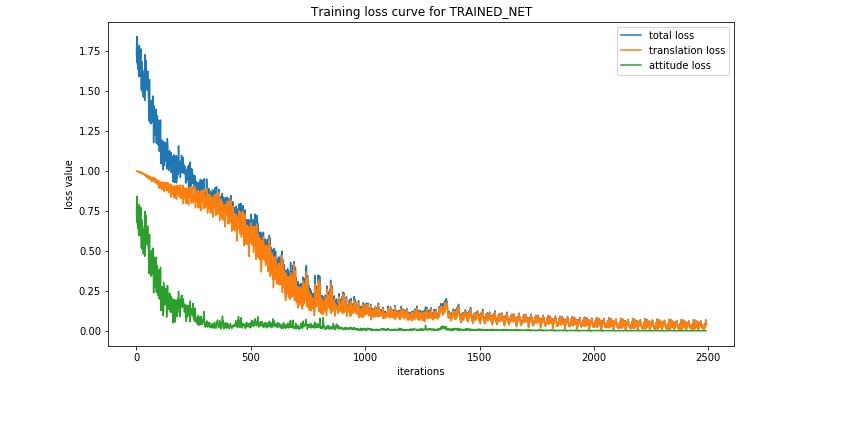

Epoch: 0 Loss: 1.6218228407625883
Epoch: 1 Loss: 1.3048169702853796
Epoch: 2 Loss: 1.091924343469008
Epoch: 3 Loss: 1.0211599255507846
Epoch: 4 Loss: 0.9614714260371227
Epoch: 5 Loss: 0.8823666268924497
Epoch: 6 Loss: 0.8270533703408152
Epoch: 7 Loss: 0.7726640318924526
Epoch: 8 Loss: 0.7077144463107271
Epoch: 9 Loss: 0.626688539981842
Epoch: 10 Loss: 0.5315682303230718
Epoch: 11 Loss: 0.41836768107594186
Epoch: 12 Loss: 0.3222112883374376
Epoch: 13 Loss: 0.2573064349170001
Epoch: 14 Loss: 0.22063637145285336
Epoch: 15 Loss: 0.19325967695353166
Epoch: 16 Loss: 0.17546622314543095
Epoch: 17 Loss: 0.15369490098278477
Epoch: 18 Loss: 0.1323789618206474
Epoch: 19 Loss: 0.12209059649480963
Epoch: 20 Loss: 0.11309305494124035
Epoch: 21 Loss: 0.1114337018357133
Epoch: 22 Loss: 0.1019088163409593
Epoch: 23 Loss: 0.10442942099751167
Epoch: 24 Loss: 0.10485974094777736
Epoch: 25 Loss: 0.1398599663714193
Epoch: 26 Loss: 0.10785328175099392
Epoch: 27 Loss: 0.0969099114244839
Epoch: 28 Loss: 0.0888

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


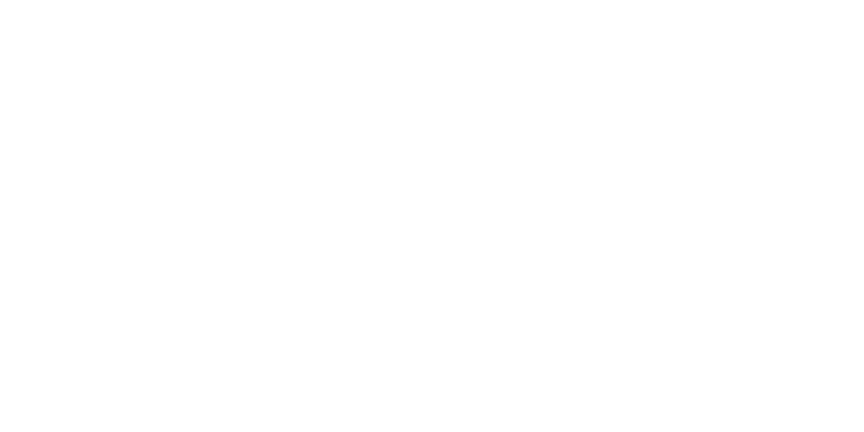

In [32]:
%%time
%matplotlib notebook
if TRAINING:
    EPOCH = 200
    trained_net = URSONet()
    if USE_GPU:
        trained_net = trained_net.cuda()

    # Criterion
    criterion = PoseNetCriterion(learn_beta=True)
    if USE_GPU:
        criterion = criterion.cuda()

    # Add all params for optimization
    param_list = [{'params': trained_net.parameters()}]
    if criterion.learn_beta:
        # Add sx and sq from loss function to optimizer params
        param_list.append({'params': criterion.parameters()})
    
    # Optimizer
    optimizer = get_optimizer(trained_net)
    # optimizer = torch.optim.SGD(params=param_list,
    #                             lr=0.001,
    #                             weight_decay=0.0001,
    #                             momentum=0.9)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
    
    # Switch to train mode
    trained_net.train()

    print("Starting Training...")

    loss_graph = [[],[],[]]

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOCH):            
        loss = train(train_loader, trained_net, optimizer, loss_graph)
        # loss = train2(train_loader, trained_net, criterion, optimizer, loss_graph)
        scheduler.step()
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for TRAINED_NET')
        ax.plot(loss_graph[0], label='total loss')
        ax.plot(loss_graph[1], label='translation loss')
        ax.plot(loss_graph[2], label='attitude loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))
%matplotlib inline

## Testing

In [33]:
def origin_reg_conversion(label, K, t_out):
    u = (label[4:11][0] + label[4:11][2]) / 2.0
    v = (label[4:11][1] + label[4:11][3]) / 2.0
    cx = K[0, 2]
    cy = K[1, 2]
    fx = K[0, 0]
    fy = K[1, 1]
#     tx = (u + t_out[0] - cx*t_out[2])/fx
#     ty = (v + t_out[1] - cy*t_out[2])/fy
    tx = t_out[2]/fx*(u + t_out[0]-cx)
    ty = t_out[2]/fy*(v + t_out[1]-cy)
    return np.array([tx, ty, t_out[2]])


In [38]:
def evaluate(val_loader, net):
    loss_graph = []
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, target, K = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()
                K = K.cuda()

            att_gt = target[:, :4].float()
            t_gt = target[:, 4:7].float()

            t, att = net(inputs)
            # t = net(inputs)
            # att = net(inputs)

#             L_t = translation_loss(t_gt, t)
            L_t = translation_loss2(t_gt, t, target[:, 7:11], K)
            L_att = attitude_loss(att_gt, att)
            # print(1-torch.norm(att))
            loss_graph.append((L_t+L_att).item())
            # loss_graph.append((L_att).item())
            total_loss += (L_t+L_att).item()# + 1.2*(torch.abs(1 - torch.norm(att)))

    return total_loss / len(val_loader)

In [39]:
# Switch to evaluation mode
# TODO: plot test loss
trained_net.eval()
test_loss = evaluate(test_loader, trained_net)
print("Test error: {}".format(test_loss))

Test error: 0.4097156134744485


Orientation error: 0.015277042975491817


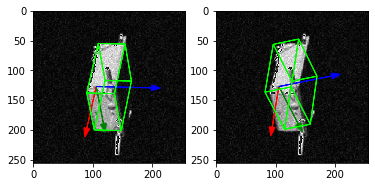

In [50]:
# Evaluation
%matplotlib inline
idx = 34
img1, label1, K1 = test_dataset[idx]

if USE_GPU:
    img1 = img1.cuda()
# att_out = trained_net.forward(img1[None])
t_out, att_out = trained_net.forward(img1[None])
t_out = t_out.detach().cpu().numpy()[0]
att_out = att_out.detach().cpu().numpy()[0]
img1 = img1.cpu()

# Plotting
size = (256, 256)
vectorScaleFactor = 4
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(img1), label1.numpy())

fig = plt.figure()
fig.add_subplot(1, 2, 1)
true_origin = training_dataset.visualize(image1, label1, K1, factor=0.6, bbox=True)

fig.add_subplot(1, 2, 2)
# MRP conversion
# new_att = mrp_to_q(att_out)
# test_dataset.dataset.visualize(image1, np.concatenate((new_att, t_out)), bbox=True)

# Origin regression from bbox center
# att_out /= np.linalg.norm(att_out)
# t_pred_new = origin_reg_conversion(label1, K1, t_out)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((label1[:4], t_pred_new)), K1, factor=0.6, bbox=True)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_pred_new)), K1, factor=0.6, bbox=True)

# Standard
att_out /= np.linalg.norm(att_out)
origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, label1[4:7])), K1, factor=0.6, bbox=True)
# origin = test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_out)), K1, factor=0.6, bbox=True)

# Prediction errors
# Difference in body frame origin (in image plane)
# t_error = np.linalg.norm(np.array(true_origin) - np.array(origin))

# Quaternion error
q_error = 1-np.dot(label1[:4], att_out)**2
# plt.title("$t_e = {{{}}}$ \n $q_e = {{{}}}$".format(t_error, q_error))
# print("Translation error: {}".format(t_error))
print("Orientation error: {}".format(q_error))

In [37]:
# Improved results regressing both at the same time. Weighting orientation might help improve results further